# Unsupervised method for First break picking.

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model](#Model)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Problem description

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

## Dataset

We exploit raw traces from Vor dataset for unsupervised model validation. All datasets descriptions are avaliable [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| 3_FBP_input_ffid_raw-500_off-800.sgy | Raw field seismogram | 2.4 Gb | 50 | 2.9 s |
| 3_FBP_input_ffid_raw-500_off-800.sgy_picking.csv | First break time | 10 Mb | 50 | - |

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.src import FieldIndex, TraceIndex, seismic_plot, SeismicBatch
from seismicpro.src.plot_utils import seismic_plot
from seismicpro.src.utils import PickingMetrics

In [2]:
markup_path = '/notebooks/egor/FB/Vor_v.2/3_FBP_manual_flatiron_picking.csv'
path_raw = '/notebooks/egor/FB/Vor_v.2/3_FBP_input_ffid_raw-500_off-800.sgy'
index = (FieldIndex(name='raw', path=path_raw, markup_path=markup_path))

In [3]:
dataset = Dataset(TraceIndex((index)), SeismicBatch)

## Model

The basic idea of this strategy is very simple and follows [Coppen's method](https://www.researchgate.net/publication/249866374_Automatic_first-breaks_picking_New_strategies_and_algorithms). The aim of the method is to distinguish the signal from the incoherent or coherent background noise in terms of their energy difference. For this purpose, we calculate the energy of the seismic trace  within two nested windows.

$$E_{1}(t) = \sum_{i = t - n_{l} + 1}^{t} {s_{i}}^2 ,$$

$$ E_{2}(t) = \sum_{i = 1}^{t} {s_{i}}^2, $$

where  $ {n_l} $ is the length of the first leading window, a parameter thatis fixed and selected a priori.   
Then we calculate the energy ratio.

$$ ER(t) = {{E_{1}(t)} \over {{E_{2}(t) + \beta}}}, $$

where $\beta$ is a stabilization constant that helps reduce the rapid fluctuations of $ER(t)$.   
Finally, we assign the first-break onset to the sample in which the derivative of the energy function is largest.

The Coppen's method requires to set two parameters: the leading window length $n_{l}$ and the stabilization constant $\beta$ . Because the leading window is supposed to capture the first-arrival energy, we set its length equal to one and half period of the first-arrival waveform. The selection of $\beta$ provides a means to control the attribute sensitivity to energy changes avoiding false picks. Based on some experimental tuning we decided to fix it at 1. Recall that the amplitudes are previously normalized to zero mean and unit variance.

In [4]:
cv = 3
pipeline = (dataset.p
                .load(components='raw', fmt='segy')
                .load(components='markup', fmt='picks')
                .normalize_traces(src='raw', dst='raw')
                .init_variable('raw', init_on_each_run=list())
                .update_variable('raw', B('raw'), mode='a')
                .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                .init_variable('true', init_on_each_run=list())
                .update_variable('true', B('markup'), mode='a')
                .mcm(src='raw', dst='energy', eps=1, l=60)
                .energy_to_picking(src='energy', dst='predictions')
                .init_variable('predictions', init_on_each_run=list())
                .update_variable('predictions', B('predictions'), mode='a'))

In [5]:
batch = pipeline.next_batch(batch_size=1000)

Take a look at raw seismic trace and corresponding energy function.

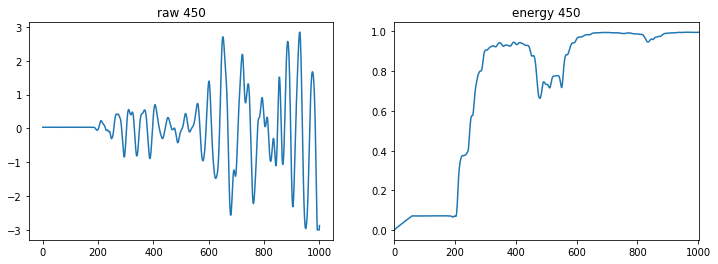

In [6]:
n = 450
batch.seismic_plot(['raw', 'energy'], index=n, figsize=(12,4))

The maximum of the derivative of the energy fucntion correspons to the picking.

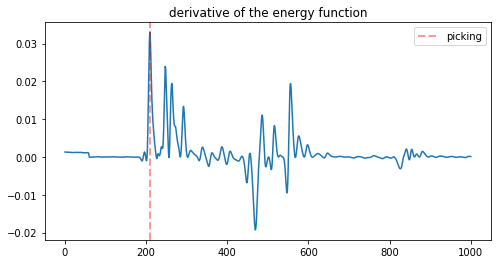

In [7]:
plt.figure(figsize=(8,4))
plt.title('derivative of the energy function')
ax1 = plt.plot(np.gradient(batch.energy[n]))
ax2 = plt.axvline(np.argmax(np.gradient(batch.energy[n])), linewidth=2, c='r', linestyle='--', alpha=0.4)
plt.legend([ax2], ['picking'])

## Inference

In [8]:
pipeline.run(batch_size=1000, n_epochs=1, bar=True)

 86%|████████▌ | 6/7 [00:02<00:00,  2.54it/s]


## Model evaluation

In [9]:
true = np.concatenate(pipeline.get_variable('true')).flatten() / 2
pred = np.concatenate(pipeline.get_variable('predictions')) 
raw = np.concatenate(pipeline.get_variable('raw'))

Mean absolute error

In [10]:
metrics = PickingMetrics(true, pred, gap=3)

In [11]:
print('MAE on validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on validation: 12.133


In [12]:
print('Accuracy on  validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on  validation: 14.82%


Take a look at the whole seismigram and model predictions.

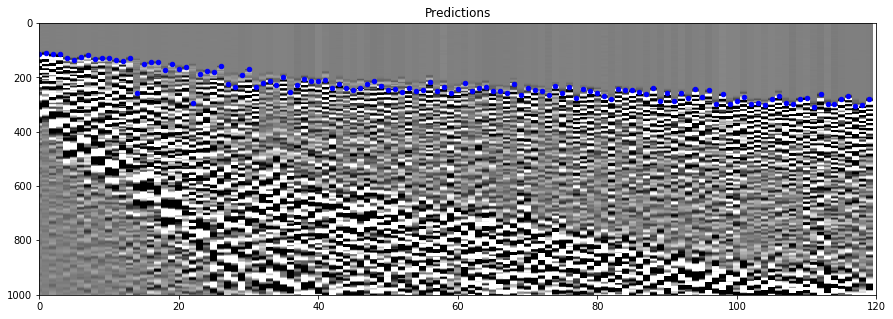

In [14]:
cv = 1
ind = range(120)
pts=(range(len(pred[ind])), pred[ind])
seismic_plot(np.concatenate(raw[ind]), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20,
             scatter_color='b', figsize=(15,5), names=['Predictions'])

Take a closer look. Ten first traces of the field.

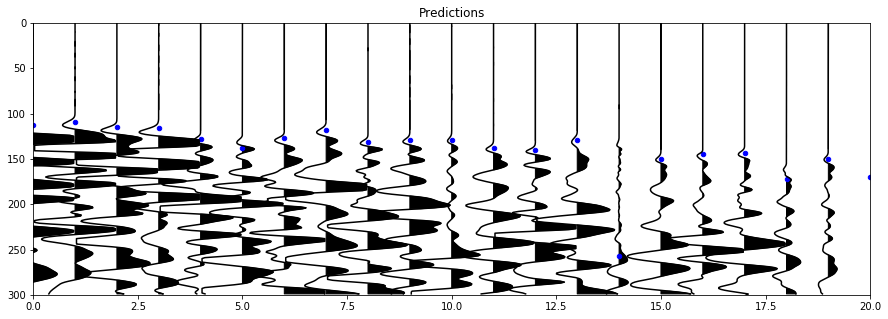

In [16]:
cv = 1
xlim = (0, 20)
ylim = (0, 300)
std = 0.3
pts=(range(len(pred)), pred)
seismic_plot(np.concatenate(raw), cmap='gray', vmin=-cv, vmax=cv, pts=pts, s=20,
             scatter_color='b', figsize=(15,5), names=['Predictions'],
             xlim=xlim, ylim=ylim, wiggle=True, std=std)

## Conclusion.

We presented unsupervised Coppen's method for First break picking task, which can be simply implemented.   
The model has two parameters $n_{l}$ - leading window length  and $\beta$ - stabilization constant which must be manually adjusted in oder to get decent results.   
Due to inconsistency among seismic traces on the same field the model prone to miss first arrival time on the traces with low signal rate.